# COMP0173: Coursework 2

The paper HEARTS: A Holistic Framework for Explainable, Sustainable, and Robust Text Stereotype Detection by Theo King, Zekun Wu et al. (2024) presents a comprehensive approach to analysing and detecting stereotypes in text [1]. The authors introduce the HEARTS framework, which integrates model explainability, carbon-efficient training, and accurate evaluation across multiple bias-sensitive datasets. By using transformer-based models such as ALBERT-V2, BERT, and DistilBERT, this research project demonstrates that stereotype detection performance varies significantly across dataset sources, underlining the need for diverse evaluation benchmarks. The paper provides publicly available datasets and code [2], allowing full reproducibility and offering a standardised methodology for future research on bias and stereotype detection in Natural Language Processing (NLP).

While the HEARTS framework evaluates stereotype detection in English, this project adapts the methodology to the Russian context. Russian stereotypes often rely on grammatical gender, morphology, and culture specific tropes. Although Russian is not classified as a low-resource language and many high-performing NLP models are available, there is currently no publicly accessible model specifically designed to detect stereotypes in Russian language. Existing models detecting toxicity or sentiment identify stereotypical and biased sentences only when they include specific patterns, such as insults, slurs, or identity-specific hate speech [8]. 

To address this gap, I introduce two fine-tuned classifiers, `AI-Forever-RuBert` [10] and `XML-RoBERTa` [11] trained on datasets `RBSA`, and `RBS`, respectively. Understanding these patterns is essential for applications such as content moderation, ensuring the safety of Russian-language LLMs, and monitoring harmful narratives across demographic groups and underrepresented societies. Adapting the HEARTS framework to this new sociolinguistic context illustrates its transferability beyond the English-speaking context and enables a more culturally grounded approach to bias detection, thereby promoting SDG 5: Gender Equality, SDG 10: Reduced Inequalities, and SDG 16: Peace, Justice, and Strong Institutions [5].

# Instructions

All figures produced during this notebook are stored in the project’s `COMP0173_Figures` directory.
The corresponding LaTeX-formatted performance comparison tables, jupyter notebooks are stored in `/COMP0173_PDF`. 
The compiled document are available as `COMP0173-CW2-TABLES.pdf` and `COMP0173_PDF/COMP0173-CW2-NOTEBOOK-XX.pdf`.
All prompts used for data augmentation are stored in `COMP0173_Prompts` and the manually collected stereotypes (with English translations) are provided in `COMP0173_Stereotypes`. 
The datasets used for model training and evaluation are stored in `COMP0173_Data` which contains: 

- rubias.tsv — RuBias dataset [6, 7]
- ruster.csv — RuSter dataset (see Part 2 of the notebook for source websites)
- rubist.csv — RBS dataset: RuBias + RuSter augmented with LLM-generated samples (Claude Sonnet), using a zero-shot prompt with examples
- rubist_second.csv — RBSA dataset: RuBias + RuSter augmented with LLM-generated samples using a second prompt version without examples

The notebooks `COMP0173_PDF/COMP0173-CW2-NOTEBOOK-P3.pdf` and `COMP0173_PDF/COMP0173-CW2-NOTEBOOK-P5.pdf` are replications of `COMP0173_PDF/COMP0173-CW2-NOTEBOOK-P2.pdf` and `COMP0173_PDF/COMP0173-CW2-NOTEBOOK-P4.pdf`, where P2 provides the new `RBSA` with second prompt (without examples) and P5 demonstrates the model running ON GPU (the results saved are from GPU fine-tuning).

# Technical Implementation (70%)

In [1]:
# %%capture
# pip install -r requirements.txt
# pip install transformers
# pip install --upgrade transformers
# pip install --upgrade tokenizers
# pip install -U sentence-transformers
# pip install natasha
# pip install datasets
# pip install --user -U nltk
# conda install -c anaconda nltk
# pip install --upgrade openai pandas tqdm
# pip install dotenv
# python -m spacy download ru_core_news_lg

In [2]:
# pip install -U pip setuptools wheel
# pip install -U spacy
# python -m spacy download en_core_web_trf
# python -m spacy download en_core_web_sm
# python -m spacy download ru_core_news_lg

# # GPU
# pip install -U 'spacy[cuda12x]'
# # GPU - Train Models
# pip install -U 'spacy[cuda12x,transformers,lookups]'

In [3]:
# Import the libraries 
import random, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(color_codes=True)
plt.style.use('seaborn-v0_8')

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')
np.random.seed(23)

warnings.filterwarnings(
    "ignore",
    message="pkg_resources is deprecated as an API"
)

In [59]:
# Import libraries 
import pandas as pd
import os
import sys
import importlib.util, pathlib
from pathlib import Path
import warnings 
from importlib import reload
from importlib.machinery import SourceFileLoader
from IPython.display import display
import pandas as pd
from pathlib import Path
import re
import difflib
import string
from collections import defaultdict
import json
import gc
import pandas as pd
import pandas as pd
from deep_translator import GoogleTranslator
from sklearn.metrics import accuracy_score, f1_score, classification_report

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.metrics import f1_score

In [34]:

import torch
import transformers
from transformers import AutoModelForMaskedLM, XLMWithLMHeadModel
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
from transformers import AutoTokenizer, AutoConfig
from transformers import TrainingArguments, Trainer
from sentence_transformers import SentenceTransformer, util
import platform
from datasets import Dataset
# import spacy 
import requests
from tqdm import tqdm
import yaml
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [6]:
sys.path.append("Exploratory Data Analysis")
sys.path.append("Model Training and Evaluation")
sys.path.append("Model Explainability")

from Initial_EDA import (
    prepare_target_variable_distribution,
    prepare_group_distribution,
    prepare_text_length_analysis,
    create_word_cloud
)

from Sentiment_Toxicity_Analysis_Ru import analyse_sentiment_and_regard

In [7]:
# # Check the GPU host (UCL access)
# print("CUDA available:", torch.cuda.is_available())
# print("Device:", torch.cuda.get_device_name(0))

# # Path
# import os
# os.chdir("/tmp/HEARTS-Text-Stereotype-Detection")
# os.getcwd()

## Part 5: Evaluate the adapted model, comparing performance metrics with the original study

Across all adapted models, `XLM-RoBERTa` achieved the highest overall performance, reaching a Macro F1 of $97.9\%$ on the RBS dataset. 
However, this result is not fully reliable, as the model showed clear signs of overfitting to LLM-generated augmentation data, limiting its practical use. 

In contrast, `AI-Forever-RuBERT` provided more stable and realistic performance across datasets, achieving around $74.3\%$ Macro F1, making it the most trustworthy binary classifier for stereotype detection in Russian. 

Logistic Regression baselines performed poorly particularly TF-IDF on RBSA ($51.8\%$) highlighting the need for deep contextual modelling rather than surface-level lexical cues.

When broken down by stereotype type, RuBERT performed best on gender $78\%$, LGBTQ+ $77\%$, and nationality $76\%$, while profession stereotypes $66\%$ were the hardest to classify, reflecting their broader semantic variability (i.e profession and socio-economic class). Multilingual tests further showed that `AI-Forever-RuBERT` generalises better than `XLM-RoBERTa` when translating English sentences into Russian, though human supervision and carefully designed few-shot prompting remain necessary during data augmentation.

![Original vs Adapted Model](COMP0173_Figures/adapted_model_scores.png)

### Helper Functions

In [8]:
def extract_macro_f1(path):
    df = pd.read_csv(path)
    row = df[df.iloc[:, 0].str.contains("macro", case=False, na=False)]
    return float(row["f1-score"].values[0])

In [9]:
def build_table(dataset_name):
    rows = []
    for model_name, folder in MODEL_FOLDERS.items():
        report_path = os.path.join(folder, dataset_name, "classification_report.csv")
        if os.path.exists(report_path):
            macro = extract_macro_f1(report_path)
            rows.append([model_name, macro])

    df = pd.DataFrame(rows, columns=["Model", "Macro F1"])
    df = df.sort_values("Macro F1", ascending=False).reset_index(drop=True)

    return df

In [ ]:
def plot_table(df, title):
    
    """
    Single-series barplot:
    - seaborn whitegrid
    - soft y-grid only
    - no black bar outlines
    - clean title & ticks
    """

    sns.set_style("whitegrid")

    models = df["Model"].tolist()
    scores = df["Macro F1"].values

    x = np.arange(len(models))

    fig, ax = plt.subplots(figsize=(6, 3), dpi=200)

    # Bars (no outlines, seaborn-like colour)
    palette = sns.color_palette("Purples_d", len(models))
    ax.bar(
        x,
        scores,
        color=palette,
        edgecolor=None,      
    )

    # X ticks
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=0, fontsize=7)

    # Y axis from 0 to 1 (Macro F1)
    ax.set_ylim(0, 1.0)
    ax.set_yticks(np.linspace(0, 1.0, 6))
    ax.tick_params(axis="y", labelsize=9)
    ax.set_ylabel("")

    # Title in same style
    ax.set_title(title, fontsize=14, fontweight="bold", pad=12, y = 1.1)

    # Grid only on y
    ax.grid(axis="y", color="0.75", linewidth=0.5)
    ax.grid(axis="x", visible=False)

    sns.despine(ax=ax)

    for xi, val in zip(x, scores):
        ax.text(
            xi,
            val + 0.015,
            f"{val:.3f}",
            ha="center",
            va="bottom",
            fontsize=8,
        )

    fig.tight_layout()
    plt.show()

In [ ]:
def f1_barplot(percent_table, title):

    sns.set_style("whitegrid")

    categories = percent_table.index.tolist()
    values = percent_table["Macro F1"].values

    # colour palette per group 
    color_map = {
        "gender":      "#c0392b",
        "profession":  "#f1c40f",
        "nationality": "#27ae60",
        "race":        "#3498db",
        "religion":    "#2c3e50",
        "lgbtq":       "#8e44ad",
        "other":       "#7f8c8d",
    }
    colors = [color_map.get(cat, "grey") for cat in categories]

    x = np.arange(len(categories))

    fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

    ax.bar(
        x,
        values,
        width=0.55,
        color=colors,
        edgecolor=None,         
    )

    # x-axis
    ax.set_xticks(x)
    ax.set_xticklabels(categories, fontsize=11)

    # y-axis
    ax.set_ylim(0, 100)
    ax.set_yticks(np.arange(0, 101, 10))
    ax.tick_params(axis='y', labelsize=9)
    ax.set_ylabel("")

    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v, pos: f"{int(v)}%"))

    # title
    ax.set_title(title, fontsize=14, fontweight="bold", pad=12)

    # seaborn-style grid
    ax.grid(axis="y", color="0.75", linewidth=0.5)
    ax.grid(axis="x", visible=False)

    sns.despine(ax=ax)

    fig.tight_layout()
    plt.show()

In [ ]:
def prepare_results(file_path, save_path):
    
    """
    Load full_results.csv, create 'categorisation',
    and save the updated CSV. Does NOT return a DataFrame.
    
    Rules:
    - If actual_label == 1 → 'stereotype_<stereotype_type>'
    - If actual_label == 0 → 'neutral'
    """
    
    df = pd.read_csv(file_path)
    
    def build_category(row):
        if row["actual_label"] == 1:
            return f"stereotype_{row['stereotype_type']}"
        else:
            return "neutral"
    
    df["categorisation"] = df.apply(build_category, axis=1)

    df.to_csv(save_path, index=False)
    print(f"Saved updated file to: {save_path}")

In [ ]:
def sample_observations_balanced(file_path, n_per_status=5, seed=42):
    
    """
    For each categorisation:
      - sample up to n_per_status correctly classified examples
      - sample up to n_per_status misclassified examples

    Returns a DataFrame with ~ 2 * n_per_status * num_categories rows
    (less if some groups are too small).
    """
    
    data = pd.read_csv(file_path)

    if 'categorisation' not in data.columns:
        raise ValueError("The CSV must contain a 'categorisation' column.")

    if not {'predicted_label', 'actual_label'}.issubset(data.columns):
        raise ValueError("The CSV must contain 'predicted_label' and 'actual_label' columns.")

    sampled_parts = []

    # Group only by categorisation (as you requested)
    for cat, group in data.groupby('categorisation'):
        same_label = group[group['predicted_label'] == group['actual_label']]
        diff_label = group[group['predicted_label'] != group['actual_label']]

        # Sample up to n_per_status from each side
        n_same = min(n_per_status, len(same_label))
        n_diff = min(n_per_status, len(diff_label))

        if n_same > 0:
            same_sample = same_label.sample(n=n_same, random_state=seed)
            sampled_parts.append(same_sample)

        if n_diff > 0:
            diff_sample = diff_label.sample(n=n_diff, random_state=seed)
            sampled_parts.append(diff_sample)

    sampled_data = pd.concat(sampled_parts, axis=0).reset_index(drop=True)

    print("Rows per categorisation in the sample:")
    print(sampled_data['categorisation'].value_counts())
    print(f"\nTotal sampled rows: {len(sampled_data)}")

    return sampled_data

In [ ]:
def build_token_ranking_string(shap_df, sentence_id, top_n=None):
    
    """
    Build a string like:
    '"housewife": 0.446, "woman": 0.159, ...'
    for one sentence_id, sorted by |SHAP| descending.
    """
    
    subset = shap_df[shap_df['sentence_id'] == sentence_id][['token', 'value_shap']]

    # Sort by absolute SHAP
    subset = subset.sort_values('value_shap', key=lambda s: s.abs(), ascending=False)

    if top_n is not None:
        subset = subset.head(top_n)

    parts = [
        f'"{tok}": {val:.3f}'
        for tok, val in zip(subset['token'], subset['value_shap'])
    ]
    return ", ".join(parts)

In [ ]:
def build_explanation_table(shap_df, sentence_df, top_n_tokens=None):
    
    """
    shap_df: token-level SHAP results
    sentence_df: sentence-level similarity results (grouped)
                 must contain: sentence_id, cosine_similarity,
                                pearson_correlation, js_divergence
    top_n_tokens: how many tokens to show in 'Token Rankings' (None = all)

    Returns: pandas DataFrame with columns similar to HEARTS Table 2.
    """
    
    rows = []

    for _, srow in sentence_df.iterrows():
        sid = srow['sentence_id']

        # Grab metadata from any row with this sentence_id
        meta = shap_df[shap_df['sentence_id'] == sid].iloc[0]

        rows.append({
            "Text Instance": meta['sentence'],
            "Predicted Label": meta['predicted_label'],
            "Actual Label": meta['actual_label'],
            "Token Rankings": build_token_ranking_string(
                shap_df, sid, top_n=top_n_tokens
            ),
            "Cosine Similarity": srow['cosine_similarity'],
            "Pearson R": srow['pearson_correlation'],
            "JS Divergence": srow['js_divergence'],
        })

    return pd.DataFrame(rows)

### Macro F1 Scores

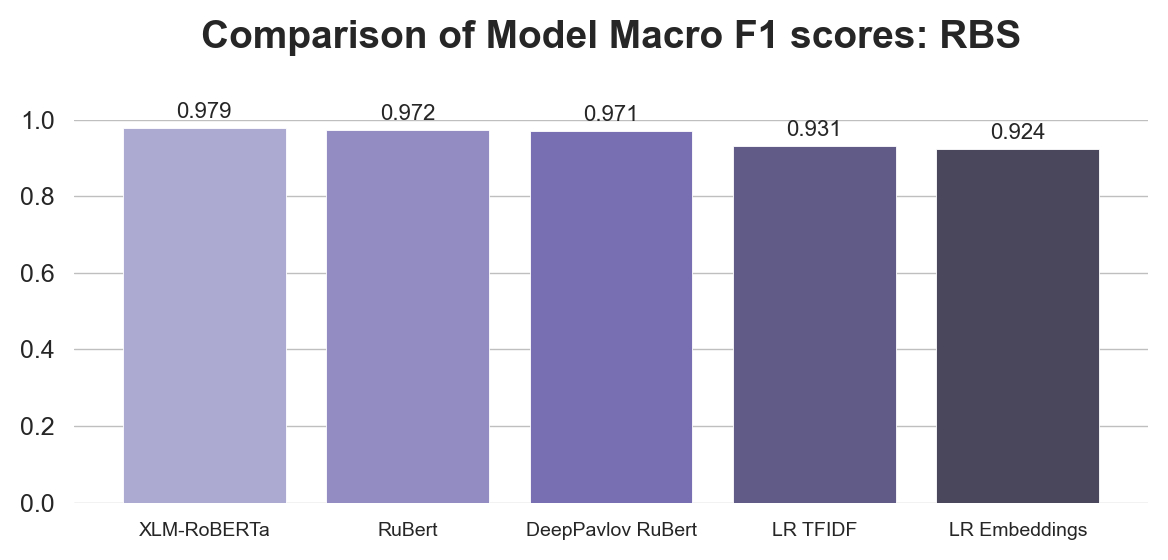

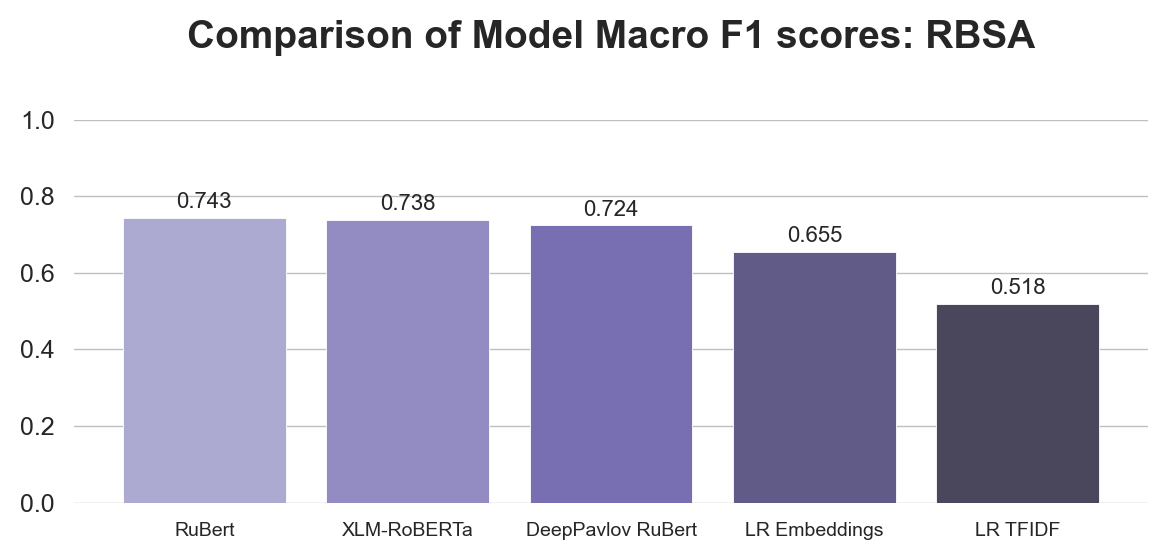

In [12]:
MODEL_FOLDERS = {
    "LR TFIDF": "result_output_LR_tfidf",
    "LR Embeddings": "result_output_LR_embedding",
    "DeepPavlov RuBert": "result_output_deeppavlov_rubert",    
    "RuBert": "result_output_ruberta_base",
    "XLM-RoBERTa": "result_output_xlm_roberta_base",
}

DATASETS = ["rubist_trained", "rubist_second_trained"]

table_A = build_table("rubist_trained")
table_B = build_table("rubist_second_trained")

plot_table(table_A, "Comparison of Model Macro F1 scores: RBS")
plot_table(table_B, "Comparison of Model Macro F1 scores: RBSA")

In [50]:
df = pd.read_csv("result_output_ruberta_base/rubist_second_trained/full_results.csv")

group_f1 = (
    df
    .groupby("stereotype_type")
    .apply(lambda g: f1_score(g["actual_label"], g["predicted_label"], average="macro"))
    .sort_index()
)

# convert to % table compatible with plotting helper
percent_table = pd.DataFrame(
    {"Macro F1": group_f1.values * 100},
    index=group_f1.index
)
percent_table

,Macro F1
stereotype_type,
gender,78.151261
lgbtq,77.228652
nationality,76.304606
profession,66.545455


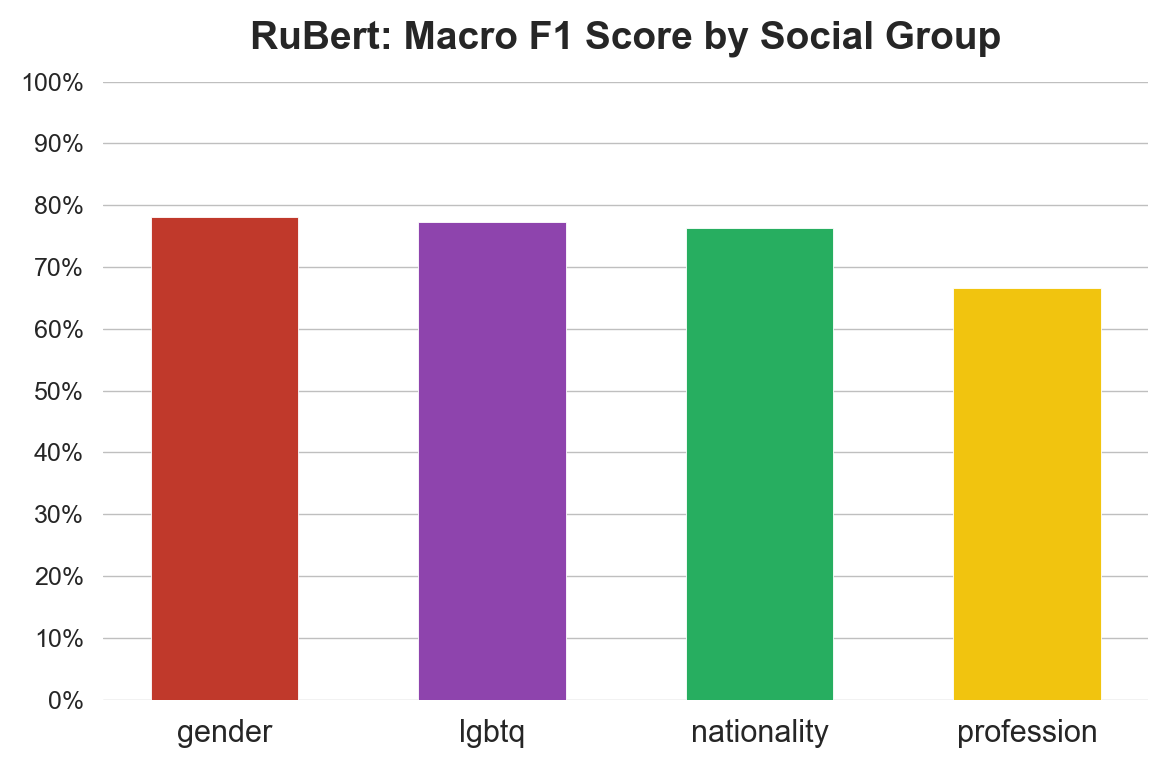

In [52]:
f1_barplot(percent_table, "RuBert: Macro F1 Score by Social Group")

### SHAP & LIME

In [29]:
from SHAP_LIME_Analysis_Ru import (sample_observations, shap_analysis, lime_analysis, compute_cosine_similarity, compute_pearson_correlation, compute_js_divergence)

file_path = 'result_output_ruberta_base/rubist_second_trained/full_results.csv'
model_path = "model_output_ruberta_base/rubist_second_trained"

prepare_results(
    "result_output_ruberta_base/rubist_second_trained/full_results.csv",
    "result_output_ruberta_base/rubist_second_trained/full_results.csv"
)

Saved updated file to: result_output_ruberta_base/rubist_second_trained/full_results.csv


In [30]:
# This gives you ≈ 50 rows (if each category has ≥5 correct and ≥5 incorrect)
sampled_data = sample_observations_balanced(
    file_path,
    n_per_status=5,
    seed=42
)

sampled_data.to_csv("COMP0173_Temp_Data/sampled_50_examples.csv", index=False)
sampled_data.head()

Rows per categorisation in the sample:
categorisation
neutral                   10
stereotype_gender         10
stereotype_lgbtq          10
stereotype_nationality    10
stereotype_profession     10
Name: count, dtype: int64

Total sampled rows: 50


,text,predicted_label,predicted_probability,actual_label,stereotype_type,dataset_name,categorisation
0,она слишком деревянная для женщины,0,0.760907,0,gender,rubist_second,neutral
1,все китайцы общительные,0,0.959988,0,nationality,rubist_second,neutral
2,психолог человек стремящийся познавать себя и ...,0,0.850051,0,profession,rubist_second,neutral
3,с программистами всегда зеленый общаться,0,0.946351,0,profession,rubist_second,neutral
4,у автомеханика пушистые руки и живой ум,0,0.961002,0,profession,rubist_second,neutral


In [31]:
# Shap
shap_results = shap_analysis(sampled_data, model_path)
print(shap_results)

lime_results = lime_analysis(sampled_data, model_path)
print(lime_results)

lime_results.to_csv('COMP0173_Results/lime_results.csv')
shap_results.to_csv('COMP0173_Results/shap_results.csv')

shap_df = pd.read_csv('COMP0173_Results/shap_results.csv')
lime_df = pd.read_csv('COMP0173_Results/lime_results.csv')

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Dataset: rubist_second - Categorisation: neutral - Predicted Label: 0 - Actual Label: 0
Dataset: rubist_second - Categorisation: neutral - Predicted Label: 0 - Actual Label: 0
Dataset: rubist_second - Categorisation: neutral - Predicted Label: 0 - Actual Label: 0
Dataset: rubist_second - Categorisation: neutral - Predicted Label: 0 - Actual Label: 0
Dataset: rubist_second - Categorisation: neutral - Predicted Label: 0 - Actual Label: 0
Dataset: rubist_second - Categorisation: neutral - Predicted Label: 1 - Actual Label: 0
Dataset: rubist_second - Categorisation: neutral - Predicted Label: 1 - Actual Label: 0
Dataset: rubist_second - Categorisation: neutral - Predicted Label: 1 - Actual Label: 0
Dataset: rubist_second - Categorisation: neutral - Predicted Label: 1 - Actual Label: 0
Dataset: rubist_second - Categorisation: neutral - Predicted Label: 1 - Actual Label: 0
Dataset: rubist_second - Categorisation: stereotype_gender - Predicted Label: 1 - Actual Label: 1
Dataset: rubist_second

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Dataset: rubist_second - Categorisation: stereotype_profession - Predicted Label: 0 - Actual Label: 1
     sentence_id        token  value_shap  \
0              0          она   -0.009527   
1              0      слишком    0.167718   
2              0   деревянная   -0.377149   
3              0          для   -0.055029   
4              0      женщины    0.000810   
..           ...          ...         ...   
296           49       пилоты   -0.046913   
297           49       всегда   -0.020005   
298           49     спокойны   -0.127602   
299           49            и   -0.035212   
300           49  невозмутимы   -0.027750   

                                 sentence        dataset  \
0      она слишком деревянная для женщины  rubist_second   
1      она слишком деревянная для женщины  rubist_second   
2      она слишком деревянная для женщины  rubist_second   
3      она слишком деревянная для женщины  rubist_second   
4      она слишком деревянная для женщины  rubist_second 

In [ ]:
# Compute similarity scores by sentence
# Columns that are common to both shap_df and lime_df, except the value columns
common_columns = [col for col in shap_df.columns if col != 'value_shap']

# Merge on metadata (sentence_id, token, etc.)
merged_df = pd.merge(shap_df, lime_df, on=common_columns, suffixes=('_shap', '_lime'))

# Group by sentence_id collect lists of SHAP and LIME values per sentence
grouped = merged_df.groupby('sentence_id').agg({
    'value_shap': list,
    'value_lime': list
}).reset_index()

# Compute similarities PER ROW (i.e. per sentence)
grouped['cosine_similarity'] = grouped.apply(
    lambda row: compute_cosine_similarity(row['value_shap'], row['value_lime']),
    axis=1
)

grouped['pearson_correlation'] = grouped.apply(
    lambda row: compute_pearson_correlation(row['value_shap'], row['value_lime']),
    axis=1
)

grouped['js_divergence'] = grouped.apply(
    lambda row: compute_js_divergence(row['value_shap'], row['value_lime']),
    axis=1
)

grouped.to_csv('COMP0173_Results/sentence_level_similarity_results.csv', index=False)

In [33]:
rbsa_shap_lime = build_explanation_table(shap_df, grouped, top_n_tokens=10)
print(rbsa_shap_lime)

                                        Text Instance  Predicted Label  \
0                  она слишком деревянная для женщины                0   
1                             все китайцы общительные                0   
2   психолог человек стремящийся познавать себя и ...                0   
3            с программистами всегда зеленый общаться                0   
4             у автомеханика пушистые руки и живой ум                0   
5                            кавказцы только общаются                1   
6   женщина всегда должна быть свободной и независ...                1   
7            у женщин прекрасно развито чувство юмора                1   
8                            из за людей все проблемы                1   
9                      канадцы знают что они – не сша                1   
10                       мужчины редко ходят к врачам                1   
11                             место женщины на кухне                1   
12                                 муж

### Model Details and Configuration

In [38]:
config = AutoConfig.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

training_args_path = os.path.join(model_path, "training_args.bin")
training_args = torch.load(training_args_path)
training_args

batch_size   = training_args.per_device_train_batch_size
learning_rate = training_args.learning_rate
epochs        = training_args.num_train_epochs

In [ ]:
# Key information
model_name      = "stereotype_bias_classifier_rubert"   
base_arch       = type(model).__name__           # e.g. 'XLMRobertaForSequenceClassification'
num_params      = sum(p.numel() for p in model.parameters())
vocab_size      = config.vocab_size
labels          = list(range(config.num_labels))  # typically [0, 1]

# Model capacity / architecture
embedding_dim   = config.hidden_size             # XLM-R uses hidden_size as embedding size
hidden_size     = config.hidden_size
intermediate    = config.intermediate_size
num_layers      = config.num_hidden_layers
num_heads       = config.num_attention_heads

# Regularisation hyperparameters
hidden_act      = config.hidden_act
hidden_dropout  = getattr(config, "hidden_dropout_prob", None)
attn_dropout    = getattr(config, "attention_probs_dropout_prob", None)
classifier_drop = getattr(config, "classifier_dropout", None)
layer_norm_eps  = config.layer_norm_eps

print("Parameters:", num_params)
print("Vocab size:", vocab_size)
print("Hidden size:", hidden_size)
print("Layers:", num_layers)
print("Heads:", num_heads)

In [43]:
hyperparams = {
    "Batch Size": batch_size,
    "Learning Rate": f"{learning_rate:.1e}",
    "Epochs": epochs,
    "Training Device": "GPU (NVIDIA Tesla T4)",   
    "Approximate Runtime": "< 10 Minutes",        
}

table_hyper = pd.DataFrame(
    list(hyperparams.items()),
    columns=["Parameter", "Value"]
)
table_hyper

,Parameter,Value
0,Batch Size,64
1,Learning Rate,2.0e-05
2,Epochs,6
3,Training Device,GPU (NVIDIA Tesla T4)
4,Approximate Runtime,< 10 Minutes


In [46]:
details = {
    "Model Name": model_name,
    "Base Architecture": base_arch,
    "Number of Parameters": f"{num_params:,}",
    "Vocabulary Size": vocab_size,
    "Labels": str(labels),

    "Model Configuration and Capacity": "",
    "Embedding Dimensionality": embedding_dim,
    "Intermediate Layer Size": intermediate,
    "Hidden Layer Size": hidden_size,
    "Number of Hidden Layers": num_layers,
    "Number of Attention Heads": num_heads,

    "Regularisation Hyperparameters": "",
    "Hidden Layer Activation": hidden_act,
    "Hidden Layer Dropout Probability": hidden_dropout,
    "Attention Head Dropout Probability": attn_dropout,
    "Classification Layer Dropout Probability": classifier_drop,
    "Layer Normalisation Epsilon": layer_norm_eps,
}

table_details = pd.DataFrame(
    list(details.items()),
    columns=["Category", "Details"]
)
table_details

,Category,Details
0,Model Name,stereotype_bias_classifier_rubert
1,Base Architecture,BertForSequenceClassification
2,Number of Parameters,"178,308,866"
3,Vocabulary Size,120138
4,Labels,"[0, 1]"
5,Model Configuration and Capacity,
6,Embedding Dimensionality,768
7,Intermediate Layer Size,3072
8,Hidden Layer Size,768
9,Number of Hidden Layers,12


In [ ]:
print(details)

### Model vs Adapted Models Perfomance


Because the adapted Russian models and the original English HEARTS models operate in different languages, use different tokenisers and embeddings, and are trained on datasets with fundamentally different distributions, a direct metric-to-metric comparison would be invalid. 

To enable a fairer evaluation, I designed a cross-lingual testing setup using translation pipelines. This allowed all models English and Russian to be assessed on versions of the same input, either translated from Russian to English or from English to Russian.
This experiment tests two things:

- How much each model relies on language-specific biases and lexical patterns.
- Whether stereotype detection generalises beyond the training language.


**Summary of Results (Table 7)**

On Russian datasets, English `ALBERT-V2` performs moderately well when fed RU -> EN translations ($67–77\%$ Macro F1), showing that stereotype cues survive translation, but its performance remains below that of native Russian `AI-Forever-RuBERT`.

`AI-Forever-RuBERT`, trained natively on Russian, achieves much stronger performance on RBSA and RBS ($73\%$ and $72.9\%$ Macro F1), confirming that it best captures Russian cultural and linguistic patterns. `XLM-Roberta` achieves very high scores on RBS ($97.5\%$), but this again reflects earlier concerns about overfitting to augmented data — its performance should be interpreted cautiously.

On English MGSD, `ALBERT-V2` reaches the expected strong results ($85\%$ Macro F1).

When MGSD is translated EN -> RU, `AI-Forever-RuBERT` drops to $61.6\%$, and `XLM-Roberta` drops further to $53.1\%$.  
This shows that Russian models struggle when fed English stereotypes, even after translation, likely because:

- MGSD stereotypes reflect Western cultural contexts absent from Russian data,  
- Translation distorts subtle pragmatic patterns,  
- `XLM-Roberta` overfitted to patterns caused by data augmentation on LLM,
- The moderate/insufficient dataset size (3,000 - 4,000)

**Interpretation**

- Stereotype detection is highly language and culture-dependent.  
- `AI-Forever-RuBERT` generalises better across languages than `XLM-Roberta`, despite `XLM-Roberta`’s high performance in Russian language, likely due to overfitting.  
- Translation alone cannot fully align cultural assumptions, meaning stereotype detection models must be trained on culturally grounded and diverse datasets.

![Original vs Adapted Model Perfomance Crosslingual](COMP0173_Figures/multi_lang_perf.png)

In [113]:
# Download holistic ai model 
albert_tokenizer = AutoTokenizer.from_pretrained("holistic-ai/bias_classifier_albertv2")
albert_model = AutoModelForSequenceClassification.from_pretrained("holistic-ai/bias_classifier_albertv2")

# Download rubert model on rbsa
rubert_tokenizer = AutoTokenizer.from_pretrained("model_output_ruberta_base/rubist_second_trained")
rubert_model = AutoModelForSequenceClassification.from_pretrained("model_output_ruberta_base/rubist_second_trained")

# Download xlm roberta model on rbs
xlm_tokenizer = AutoTokenizer.from_pretrained("model_output_xlm_roberta_base/rubist_trained")
xlm_model = AutoModelForSequenceClassification.from_pretrained("model_output_xlm_roberta_base/rubist_trained")

loading file spiece.model from cache at /Users/rinlobachevskii/.cache/huggingface/hub/models--holistic-ai--bias_classifier_albertv2/snapshots/c1a5e087e6bfdfb7fc9e7333a8028d8f29ba6201/spiece.model
loading file tokenizer.json from cache at /Users/rinlobachevskii/.cache/huggingface/hub/models--holistic-ai--bias_classifier_albertv2/snapshots/c1a5e087e6bfdfb7fc9e7333a8028d8f29ba6201/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /Users/rinlobachevskii/.cache/huggingface/hub/models--holistic-ai--bias_classifier_albertv2/snapshots/c1a5e087e6bfdfb7fc9e7333a8028d8f29ba6201/special_tokens_map.json
loading file tokenizer_config.json from cache at /Users/rinlobachevskii/.cache/huggingface/hub/models--holistic-ai--bias_classifier_albertv2/snapshots/c1a5e087e6bfdfb7fc9e7333a8028d8f29ba6201/tokenizer_config.json
loading configuration file config.json from cache at /Users/rinlobachevskii/.cache/huggingface/hub/models--holistic-ai--bi

In [110]:
def get_predictions(model, tokenizer, texts):
    preds = []
    for t in texts:
        enc = tokenizer(t, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            logits = model(**enc).logits
        preds.append(int(torch.argmax(logits)))
    return preds

In [117]:
from BERT_Models_Fine_Tuning_Russian import (data_loader, train_model, evaluate_model)

_, test_data_rbsa = data_loader(csv_file_path='COMP0173_Data/rubist_second.csv', labelling_criteria='stereotype', dataset_name='rubist_second', sample_size=1000000, num_examples=5)
rubert_test = test_data_rbsa.groupby("category", group_keys=False).apply(
    lambda x: x.sample(n=100, random_state=42)
)

_, test_data_rbs = data_loader(csv_file_path='COMP0173_Data/rubist.csv', labelling_criteria='stereotype', dataset_name='rubist', sample_size=1000000, num_examples=5)
xlm_test = test_data_rbs.groupby("category", group_keys=False).apply(
    lambda x: x.sample(n=100, random_state=42)
)

First few examples from the training data:
     stereotype_type                                           text  category  \
1005          gender                     мужчинам нужен только секс         1   
1001          gender           мужчина рисует на работу каждый день         0   
2619     nationality               французы рисуют очень много сыра         0   
2213          gender  женщина успешна независимо от наличия мужчины         0   
934           gender    мужчина партнер семейства а женщина партнер         0   

          data_name  
1005  rubist_second  
1001  rubist_second  
2619  rubist_second  
2213  rubist_second  
934   rubist_second  
First few examples from the testing data:
     stereotype_type                                               text  \
80        profession             чтобы быть музыкантом нужно иметь шкаф   
1814          gender                    все девочки пылесосят мальчиков   
2277      profession  эйчар это человек который не взяли больше нику...

In [118]:
from BERT_Models_Fine_Tuning import (data_loader)
_, test_data_mgsd = data_loader(csv_file_path='Model Training and Evaluation/MGSD.csv', labelling_criteria='stereotype', dataset_name='MGSD', sample_size=1000000, num_examples=5)

albert_test = test_data_mgsd.groupby("label", group_keys=False).apply(
    lambda x: x.sample(n=100, random_state=42)
)

First few examples from the training data:
        group                                               text  label  \
38518    race  Syria is a well known area nowadays. There is ...      1   
12979    race                   The people of germany are angry.      1   
35494    race  Lebanon is a small country in the Middle East ...      1   
42213    race  We have a french tutor. She is very humble and...      0   
16293  gender                              Every male acts dumb.      1   

      data_name  
38518      MGSD  
12979      MGSD  
35494      MGSD  
42213      MGSD  
16293      MGSD  
First few examples from the testing data:
            group                                               text  label  \
17851        race      When i see an arab, i think they are a happy.      0   
37449        race  People in India dress differently. The types o...      0   
23634      gender    Everyone has a grandmother. The bridge is long.      0   
36047        race  Cameroon is a country

In [119]:
# RBSA: rubert_test (RuBERT dataset)
rubert_test["text_en"] = rubert_test["text"].apply(
    lambda x: GoogleTranslator(source="ru", target="en").translate(x)
)

rubert_test["pred_albert"] = get_predictions(
    albert_model, albert_tokenizer, rubert_test["text_en"]
)

rubert_test["pred_rubert"] = get_predictions(
    rubert_model, rubert_tokenizer, rubert_test["text"]
)

print("ALBERT on translated RBSA")
print("Accuracy:", accuracy_score(rubert_test["category"], rubert_test["pred_albert"]))
print("Macro F1:", f1_score(rubert_test["category"], rubert_test["pred_albert"], average="macro"))
print(classification_report(rubert_test["category"], rubert_test["pred_albert"]))

print("\nRuBERT on Russian RBSA")
print("Accuracy:", accuracy_score(rubert_test["category"], rubert_test["pred_rubert"]))
print("Macro F1:", f1_score(rubert_test["category"], rubert_test["pred_rubert"], average="macro"))
print(classification_report(rubert_test["category"], rubert_test["pred_rubert"]))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


ALBERT on translated RBSA
Accuracy: 0.675
Macro F1: 0.6698412698412699
              precision    recall  f1-score   support

           0       0.64      0.80      0.71       100
           1       0.73      0.55      0.63       100

    accuracy                           0.68       200
   macro avg       0.69      0.68      0.67       200
weighted avg       0.69      0.68      0.67       200


RuBERT on Russian RBSA
Accuracy: 0.73
Macro F1: 0.7286704853783539
              precision    recall  f1-score   support

           0       0.70      0.80      0.75       100
           1       0.77      0.66      0.71       100

    accuracy                           0.73       200
   macro avg       0.73      0.73      0.73       200
weighted avg       0.73      0.73      0.73       200



In [120]:
# RBS: xlm_test 
xlm_test["text_en"] = xlm_test["text"].apply(
    lambda x: GoogleTranslator(source="ru", target="en").translate(x)
)

xlm_test["pred_albert"] = get_predictions(
    albert_model, albert_tokenizer, xlm_test["text_en"]
)

xlm_test["pred_xlm"] = get_predictions(
    xlm_model, xlm_tokenizer, xlm_test["text"]
)

print("\nALBERT on translated RBS")
print("Accuracy:", accuracy_score(xlm_test["category"], xlm_test["pred_albert"]))
print("Macro F1:", f1_score(xlm_test["category"], xlm_test["pred_albert"], average="macro"))
print(classification_report(xlm_test["category"], xlm_test["pred_albert"]))

print("\nXLM-R on Russian RBS")
print("Accuracy:", accuracy_score(xlm_test["category"], xlm_test["pred_xlm"]))
print("Macro F1:", f1_score(xlm_test["category"], xlm_test["pred_xlm"], average="macro"))
print(classification_report(xlm_test["category"], xlm_test["pred_xlm"]))


ALBERT on translated RBS
Accuracy: 0.775
Macro F1: 0.7694613079228464
              precision    recall  f1-score   support

           0       0.71      0.93      0.81       100
           1       0.90      0.62      0.73       100

    accuracy                           0.78       200
   macro avg       0.80      0.78      0.77       200
weighted avg       0.80      0.78      0.77       200


XLM-R on Russian RBS
Accuracy: 0.975
Macro F1: 0.9749993749843746
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       100
           1       0.98      0.97      0.97       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



In [121]:
# Translate MGSD English → Russian
albert_test["text_ru"] = albert_test["text"].apply(
    lambda x: GoogleTranslator(source="en", target="ru").translate(x)
)

# ALBERT on original English MGSD
albert_test["pred_albert"] = get_predictions(
    albert_model, albert_tokenizer, albert_test["text"]
)

# RuBERT on translated Russian MGSD
albert_test["pred_rubert"] = get_predictions(
    rubert_model, rubert_tokenizer, albert_test["text_ru"]
)

# XLM-R on translated Russian MGSD
albert_test["pred_xlm"] = get_predictions(
    xlm_model, xlm_tokenizer, albert_test["text_ru"]
)

print("ALBERT on English MGSD")
print("Accuracy:", accuracy_score(albert_test["label"], albert_test["pred_albert"]))
print("Macro F1:", f1_score(albert_test["label"], albert_test["pred_albert"], average="macro"))
print(classification_report(albert_test["label"], albert_test["pred_albert"]))

print("\nRuBERT on translated MGSD (EN→RU)")
print("Accuracy:", accuracy_score(albert_test["label"], albert_test["pred_rubert"]))
print("Macro F1:", f1_score(albert_test["label"], albert_test["pred_rubert"], average="macro"))
print(classification_report(albert_test["label"], albert_test["pred_rubert"]))

print("\nXLM-R on translated MGSD (EN→RU)")
print("Accuracy:", accuracy_score(albert_test["label"], albert_test["pred_xlm"]))
print("Macro F1:", f1_score(albert_test["label"], albert_test["pred_xlm"], average="macro"))
print(classification_report(albert_test["label"], albert_test["pred_xlm"]))


=== ALBERT on English MGSD ===
Accuracy: 0.85
Macro F1: 0.8494580489763148
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       100
           1       0.90      0.79      0.84       100

    accuracy                           0.85       200
   macro avg       0.86      0.85      0.85       200
weighted avg       0.86      0.85      0.85       200


=== RuBERT on translated MGSD (EN→RU) ===
Accuracy: 0.64
Macro F1: 0.616
              precision    recall  f1-score   support

           0       0.59      0.89      0.71       100
           1       0.78      0.39      0.52       100

    accuracy                           0.64       200
   macro avg       0.69      0.64      0.62       200
weighted avg       0.69      0.64      0.62       200


=== XLM-R on translated MGSD (EN→RU) ===
Accuracy: 0.55
Macro F1: 0.53125
              precision    recall  f1-score   support

           0       0.58      0.35      0.44       100
           1 

### Failure Cases 

**Translation Noise**    
Literal translations can distort pragmatic cues, weakening or altering the original stereotype signals. 

**Overfitting in `XLM-Roberta`**    
`XLM-Roberta` performs poorly on English MGSD after being fine-tuned on Russian, indicating that:    
- its strong performance in Russian reflects the memorisation of patterns generated by large language models,    
- its multilingual representations are not sufficiently aligned for effective stereotype detection. 

**Limited Dataset Size and Diversity**    
The small scale of the RBS/RBSA (approximately 3,000 to 4,000 examples) limits the models’ ability to learn stereotype trends, particularly in cross-lingual contexts.

**Multi-stereotype Sentences**    
Sentences containing overlapping stereotypes (e.g., gender and profession) are often misclassified because models tend to default to the dominant pattern learned during training. 

In overall, these failures indicate that cross-lingual stereotype detection relies not only on translation quality but also on cultural grounding, semantic robustness, and dataset diversity. Addressing these challenges requires larger Russian datasets and improved human-supervised annotation. The RBS experiment also showed that adding zero-shot examples to large language model prompts can lead to repetitive, easily recognisable patterns that models may overfit. In the RBSA dataset, the issue was that the LLM retained some negative sentiment when generating "neutral" sentences.

# References 

[1] Theo King, Zekun Wu, Adriano Koshiyama, Emre Kazim, and Philip Treleaven. 2024.
HEARTS: A holistic framework for explainable, sustainable and robust text stereotype detection.
arXiv preprint arXiv:2409.11579.
Available at: https://arxiv.org/abs/2409.11579
(Accessed: 4 December 2025).
https://doi.org/10.48550/arXiv.2409.11579

[2] Theo King, Zekun Wu, Adriano Koshiyama, Emre Kazim, and Philip Treleaven. 2024.
HEARTS-Text-Stereotype-Detection (GitHub Repository).
Available at: https://github.com/holistic-ai/HEARTS-Text-Stereotype-Detection
(Accessed: 4 December 2025).

[3] Theo King, Zekun Wu, Adriano Koshiyama, Emre Kazim, and Philip Treleaven. Holistic AI. 2024.
EMGSD: Expanded Multi-Group Stereotype Dataset (HuggingFace Dataset).
Available at: https://huggingface.co/datasets/holistic-ai/EMGSD
(Accessed: 4 December 2025).

[4] University College London Technical Support Group (TSG).
2025. GPU Access and Usage Documentation.
Available at: https://tsg.cs.ucl.ac.uk/gpus/
(Accessed: 6 December 2025).

[5] United Nations. 2025. The 2030 Agenda for Sustainable Development. 
Available at: https://sdgs.un.org/2030agenda 
(Accessed: 6 December 2025).

[6] Veronika Grigoreva, Anastasiia Ivanova, Ilseyar Alimova, and Ekaterina Artemova. 2024.
RuBia: A Russian Language Bias Detection Dataset.
Available at: https://arxiv.org/abs/2403.17553
(Accessed: 9 December 2025).

[7] Veronika Grigoreva, Anastasiia Ivanova, Ilseyar Alimova, and Ekaterina Artemova. 2024.
RuBia-Dataset (GitHub Repository).
Available at: https://github.com/vergrig/RuBia-Dataset
(Accessed: 9 December 2025).

[8] Sismetanin. 2020. Toxic Comments Detection in Russian (GitHub Repository).
Available at: https://github.com/sismetanin/toxic-comments-detection-in-russian
(Accessed: 9 December 2025).

[9] DeepPavlov. 2019. RuBERT-base-cased (Hugging Face Model).
Available at: https://huggingface.co/DeepPavlov/rubert-base-cased
(Accessed: 9 December 2025).

[10] AI-Forever. 2023. RuBERT-base (Hugging Face Model).
Available at: https://huggingface.co/ai-forever/ruBert-base
(Accessed: 9 December 2025).

[11] Hugging Face. 2024. XLM-RoBERTa: Model Documentation.
Available at: https://huggingface.co/docs/transformers/en/model_doc/xlm-roberta
(Accessed: 9 December 2025).

[12] DeepPavlov. 2020. ruBERT-base-cased-sentence (Hugging Face Model).
Available at: https://huggingface.co/DeepPavlov/rubert-base-cased-sentence
(Accessed: 9 December 2025).